In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import re


In [ ]:
print(pd.__version__)

1.3.4


In [ ]:
import geopandas as gpd


In [5]:
df = pd.read_csv("tsa_claims2.csv",low_memory=False)

#Format columns nicely for dataframe index
df.columns = [s.strip().replace(" ","_") for s in df.columns]

#Rename date columns
df["Date_Received_String"] = df.Date_Received
df["Incident_Date_String"] = df.Incident_Date
df.drop(["Date_Received","Incident_Date"], axis=1, inplace=True)

print("Rows:", len(df))

Rows: 204267


In [ ]:
df

,Claim_Number,Airport_Code,Airport_Name,Airline_Name,Claim_Type,Claim_Site,Item,Claim_Amount,Status,Close_Amount,Disposition,Date_Received_String,Incident_Date_String
0,0909802M,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,$350.00,Approved,$350.00,Approve in Full,4-Jan-02,12/12/2002 0:00
1,0202417M,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),$100.00,Settled,$50.00,Settle,2-Feb-02,1/16/2004 0:00
2,0202445M,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,$278.88,Settled,$227.92,Settle,4-Feb-02,11/26/2003 0:00
3,0909816M,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),$50.00,Approved,$50.00,Approve in Full,7-Feb-02,1/6/2003 0:00
4,2005032379513,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,$84.79,Approved,$84.79,Approve in Full,18-Feb-02,2/5/2005 0:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204262,2015120427297,-,-,-,Property Damage,Checked Baggage,Baggage/Cases/Purses; Books; Magazines & Other...,-,-,NaN,NaN,20-Nov-15,16-Oct-15
204263,2015123027969,-,-,-,Property Damage,Checked Baggage,Audio/Video; Home Decor,-,-,NaN,NaN,17-Dec-15,2-Dec-15
204264,2016010428072,-,-,-,Passenger Property Loss,Checked Baggage,Clothing,-,-,NaN,NaN,22-Dec-15,20-Dec-15
204265,2016011328300,-,-,-,Passenger Property Loss,Checked Baggage,Tools & Home Improvement Supplies,-,-,NaN,NaN,30-Dec-15,28-Dec-15


Data Cleaning


In [ ]:
# Check distribution of nulls per row
temp = df.isnull().sum(axis=1).value_counts().sort_index()
print ("Nulls    Rows     Cum. Rows")
for i in range(len(temp)):
    print ("{:2d}: {:10d} {:10d}".format(temp.index[i], temp[i], temp[i:].sum()))

Nulls    Rows     Cum. Rows
 0:      94848     204267
 1:      32404     109419
 2:      66106      77015
 3:       4582      10909
 4:       1970       6327
 5:       2253       4357
 6:        977       2104
 7:        321       1127
 8:        634        806
 9:         42        172
10:        106        130
11:         19         24
12:          5          5


I found that the Airline, Airport, Claim Type, Claim Site, and Item columns have many nulls. I can treat these nulls as "Other" or "Missing" since they’re categorical values.

For the Claim Amount, Incident Date, and Date Received columns, which are numerical, I’ll discard any entries with null values, as there's no straightforward way to assign them a value

In [ ]:
# Check distribution of nulls per column
df.isnull().sum().sort_values(ascending=False)

Disposition             72908
Close_Amount            68952
Airline_Name            34374
Airport_Code             8524
Airport_Name             8524
Claim_Type               7913
Claim_Amount             4043
Item                     3966
Incident_Date_String     2183
Claim_Site                740
Date_Received_String      263
Status                      5
Claim_Number                0
dtype: int64

Status has 5 nulls. I have to discard those rows, since that's the variable I'm trying to predict

In [ ]:
#Drop rows with too many nulls
df.dropna(thresh=6, inplace=True)

#Fill NA for categorical columns
fill_columns = ["Airline_Name","Airport_Name","Airport_Code","Claim_Type","Claim_Site","Item"]
df[fill_columns] = df[fill_columns].fillna("-")

#Set NA Claim Amount to 0. Zeros are dropped later in the code.
df["Claim_Amount"] = df.Claim_Amount.fillna("$0.00")

#Dropping these nulls later on:
#  Incident Date / Date Received
#  Status

print(len(df))

203461


I am currently cleaning the dataset, which contains various values, including inconsistent spellings for the cases im trying to predict(e.g., "Denied" vs. "Deny"). Additionally, there are entries representing unsettled claims, such as "-", "Insufficient," and "In litigation."

In [ ]:
df.Status.str.split(";").map(lambda x: "Null" if type(x)==float else x[0]).value_counts()

Denied                                               68336
Approved                                             34997
Deny                                                 28237
Settled                                              27955
-                                                    12752
Approve in Full                                      12364
Canceled                                              6651
Settle                                                5766
Insufficient                                          4972
Closed as a contractor claim                          1312
In litigation                                          108
In review                                                9
Claim has been assigned for further investigation        1
Pending response from claimant                           1
Name: Status, dtype: int64

collapse the inconsistent spellings and remove the non-final statuses

In [ ]:
valid_targets = ['Denied','Approved','Deny','Settled','Approve in Full', 'Settle']

df = df[df.Status.isin(valid_targets)]
df.Status.replace("Approve in Full","Approved",inplace=True)
df.Status.replace("Deny","Denied",inplace=True)
df.Status.replace("Settle","Settled",inplace=True)

print(df.Status.value_counts())
print(len(df))

Denied      96573
Approved    47361
Settled     33721
Name: Status, dtype: int64
177655


c:\Users\ofent\Documents\New folder\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


The "Date Received" is formatted consistently, but some dates are incorrect. Since we only need records from 2002 to 2014, let's drop any that fall outside this range.



In [ ]:
df.dropna(subset=["Date_Received_String"], inplace=True)

df["Date_Received"] = pd.to_datetime(df.Date_Received_String,format="%d-%b-%y")

df = df[df.Date_Received.dt.year.isin(range(2002,2014+1))]

print(df.Date_Received.dt.year.value_counts().sort_index())

c:\Users\ofent\Documents\New folder\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ofent\AppData\Local\Temp/ipykernel_13928/194089928.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date_Received"] = pd.to_datetime(df.Date_Received_String,format="%d-%b-%y")


2002      782
2003    19367
2004    26621
2005    22494
2006    17662
2007    17383
2008    15253
2009    11598
2010     9729
2011     9795
2012     8891
2013     6233
2014     5118
Name: Date_Received, dtype: int64


There are inconsistencies in the "Incident Date" formats, with some as 20/jan/09 and others as 01/20/09. Let's create a function to standardize these formats for conversion to DateTime objects.

In [ ]:
month_dict = {"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12}

def format_dates(regex, date_string):
    '''
    Formats the date string from 2014 entries to be consistent with the rest of the doc 
    Inputs: 
        regex - compiled re with three groups corresponding to {day}/{month (abbrev.)}/{Year}
        date_string - string to be formatted matching the regex
    Outputs: 
        If regex match, return formatted string of form {Month}/{Day}/{Year}; else return original string
    '''
    m = regex.match(date_string)
    if(m):
        day, month, year = m.group(1,2,3)
        return "{}/{}/{}".format(month_dict[month],day,"20"+year)
    else:
        return date_string

The "Incident Date" contains both date and time, so we'll separate the time before formatting the dates. Unfortunately, many rows lack the time component, making that part unusable. There are also a few other inconsistencies to fix. After addressing these issues, we can apply the formatting function we created earlier.

In [ ]:
df.dropna(subset=["Incident_Date_String"], inplace=True)

df.Incident_Date_String.replace("6/30/10","06/30/2010 16:30",inplace=True)

df["Incident_Date_String"] = df.Incident_Date_String.str.replace("-","/")
df["Incident_Date_String"] = df.Incident_Date_String.str.lower()

df["Incident_Time"] = df.Incident_Date_String.str.split(" ").map(lambda x: x[-1])
df["Incident_Date"] = df.Incident_Date_String.str.split(" ").map(lambda x: x[0])

regex = re.compile(r"/[a-z]{3}/[0-9]{4}")
df = df[df.Incident_Date.map(lambda x: not bool(regex.search(x)))].sort_values(["Date_Received"])

regex = re.compile(r"(\d*)/([a-z]{3})/(1[1-4])$")
df["Incident_Date"] = df.Incident_Date.map(lambda x: format_dates(regex,x) )

df["Incident_Date"] = pd.to_datetime(df.Incident_Date,format="%m/%d/%Y")
df = df[df.Incident_Date.dt.year.isin(range(2002,2014+1))]

print(df.Incident_Date.dt.year.value_counts().sort_index())
print(len(df))

2002     1631
2003    21859
2004    26166
2005    21209
2006    17436
2007    17076
2008    14776
2009    10080
2010    10879
2011     9848
2012     8755
2013     5999
2014     4293
Name: Incident_Date, dtype: int64
170007


First, we see that some airport codes are linked to multiple distinct airport names, but this is due to excess whitespace. This issue is easy to fix.

In [ ]:
temp = df.groupby("Airport_Code").Airport_Name.nunique().sort_values(ascending=False)
print(df[df.Airport_Code.isin(temp[temp>1].index)].groupby("Airport_Code").Airport_Name.unique().head())
print("\n---\n")

df["Airport_Code"] = df.Airport_Code.str.strip()
df["Airport_Name"] = df.Airport_Name.str.strip()

temp = df.groupby("Airport_Code").Airport_Name.nunique().sort_values(ascending=False)
print(df[df.Airport_Code.isin(temp[temp>1].index)].groupby("Airport_Code").Airport_Name.unique().head())

Airport_Code
BOS    [Boston (Logan) International Airport, Boston ...
BUR                                [Bob Hope, Bob Hope ]
DEN    [Denver International Airport, Denver Internat...
DFW    [Dallas-Fort Worth International Airport, Dall...
DUJ    [Dubois Jefferson County, Dubois Jefferson Cou...
Name: Airport_Name, dtype: object

---

Series([], Name: Airport_Name, dtype: object)


Next, I'm consolidating the airports that appear infrequently in the claims to simplify the dataset. I’ll group together those with fewer than 200 claims, which is about 0.01% of the total data.

In [ ]:
temp = df.Airport_Code.value_counts()
print("Total: {} airports, {} complaints".format(temp.count(),temp.sum()))
for num in range(1000,1,-100):
    print("Under {}: {} airports, {} complaints".format(num, temp[temp<num].count(),temp[temp<num].sum()))

level = 200
def set_other(row, keep_items):
    if row.Airport_Code in keep_items:
        row["Airport_Code_Group"] = row.Airport_Code
        row["Airport_Name_Group"] = row.Airport_Name
    else:
        row["Airport_Code_Group"] = 'Other'
        row["Airport_Name_Group"] = 'Other'
    return row

keep_set = set(temp[temp>=level].index)
df = df.apply(lambda x: set_other(x,keep_set),axis=1)

Total: 450 airports, 170007 complaints
Under 1000: 407 airports, 42960 complaints
Under 900: 402 airports, 38199 complaints
Under 800: 397 airports, 34015 complaints
Under 700: 392 airports, 30339 complaints
Under 600: 384 airports, 25052 complaints
Under 500: 378 airports, 21592 complaints
Under 400: 372 airports, 18959 complaints
Under 300: 365 airports, 16513 complaints
Under 200: 348 airports, 12258 complaints
Under 100: 307 airports, 6642 complaints


For airlines, let's consolidate names that seem to be subsidiary/parent or have inconsistent naming.

In [ ]:
df["Airline_Name"] = df.Airline_Name.str.strip().str.replace(" ","")
df.Airline_Name.replace("AmericanEagle","AmericanAirlines",inplace=True)
df.Airline_Name.replace("AmericanWest","AmericaWest",inplace=True)
df.Airline_Name.replace("AirTranAirlines(donotuse)","AirTranAirlines",inplace=True)
df.Airline_Name.replace("AeroflotRussianInternational","AeroFlot",inplace=True)
df.Airline_Name.replace("ContinentalExpressInc","ContinentalAirlines",inplace=True)
df.Airline_Name.replace("Delta(Song)","DeltaAirLines",inplace=True)
df.Airline_Name.replace("FrontierAviationInc","FrontierAirlines",inplace=True)
df.Airline_Name.replace("NorthwestInternationalAirwaysLtd","NorthwestAirlines",inplace=True)
df.Airline_Name.replace("SkywestAirlinesAustralia","SkywestAirlinesIncUSA",inplace=True)

df.Airline_Name.value_counts().head(10)
print(len(df))

170007


1. What is the most common type of insurance claim?

In [ ]:
print(df.Claim_Type.value_counts())
print(df.Claim_Site.value_counts())

Passenger Property Loss    98472
Property Damage            64163
-                           5384
Personal Injury              884
Passenger Theft              429
Employee Loss (MPCECA)       427
Motor Vehicle                238
Complaint                      6
Wrongful Death                 3
Bus Terminal                   1
Name: Claim_Type, dtype: int64
Checked Baggage    135738
Checkpoint          32628
Other                1037
-                     308
Motor Vehicle         286
Bus Station            10
Name: Claim_Site, dtype: int64


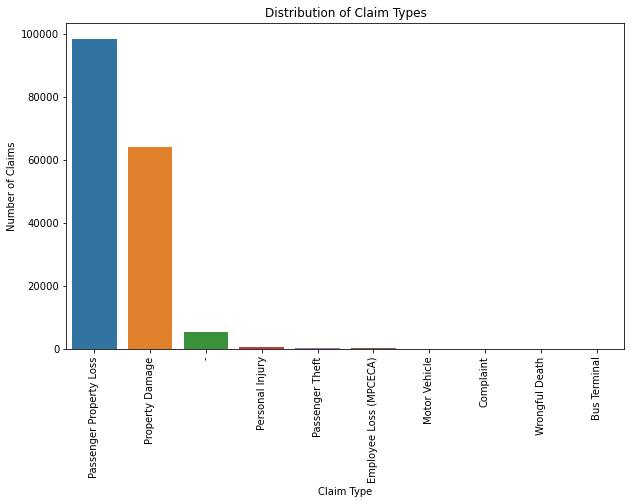

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df['Claim_Type'].value_counts().index, y=df['Claim_Type'].value_counts().values)
plt.title('Distribution of Claim Types')
plt.xticks(rotation=90)
plt.ylabel('Number of Claims')
plt.xlabel('Claim Type')
plt.show()




2. Which claim site within the airport are claims most commonly filed for?

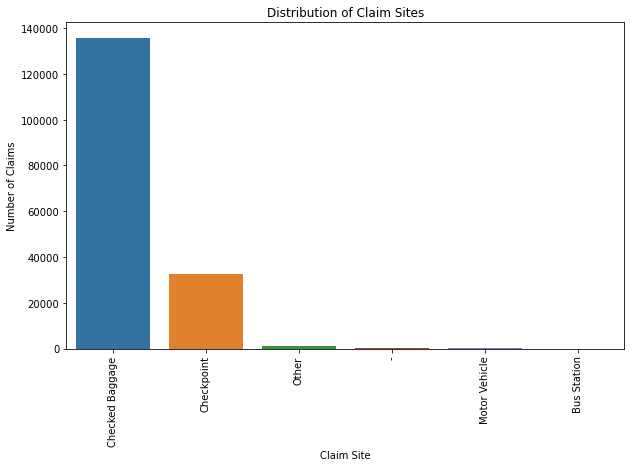

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df['Claim_Site'].value_counts().index, y=df['Claim_Site'].value_counts().values)
plt.title('Distribution of Claim Sites')
plt.xticks(rotation=90)
plt.ylabel('Number of Claims')
plt.xlabel('Claim Site')
plt.show()

3. What type of claim is made most at each claim site?

In [ ]:
claim_counts = df.groupby(['Claim_Site', 'Claim_Type']).size().reset_index(name='counts')

most_common_claims = claim_counts.loc[claim_counts.groupby('Claim_Site')['counts'].idxmax()]

print(most_common_claims)


         Claim_Site               Claim_Type  counts
2                 -  Passenger Property Loss     120
7       Bus Station          Property Damage       6
13  Checked Baggage  Passenger Property Loss   84125
24       Checkpoint          Property Damage   17201
27    Motor Vehicle            Motor Vehicle     209
38            Other          Property Damage     331


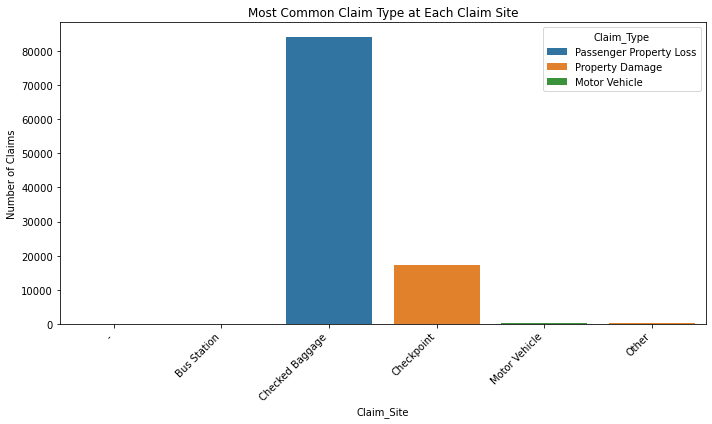

In [ ]:
claim_counts = df.groupby(['Claim_Site', 'Claim_Type']).size().reset_index(name='counts')

most_common_claims = claim_counts.loc[claim_counts.groupby('Claim_Site')['counts'].idxmax()]

plt.figure(figsize=(10, 6))
sns.barplot(data=most_common_claims, x='Claim_Site', y='counts', hue='Claim_Type', dodge=False)
plt.title('Most Common Claim Type at Each Claim Site')
plt.ylabel('Number of Claims')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

4. What is the typical claim amount?

I cleaned the Claim_Amount column by removing characters like ;, $, and -, then converted it to numeric values. I used pd.to_numeric() with errors="coerce" to handle any invalid values by turning them into NaN. After that, I switched from sns.distplot() to sns.histplot() for plotting, since distplot is deprecated. Lastly, I made a copy of the dataframe to keep the original data intact for later use

C:\Users\ofent\AppData\Local\Temp/ipykernel_12020/1290776825.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["Claim_Amount"] = df.Claim_Amount.str.replace("[;$-]", "", regex=True).str.replace("$", "").str.replace("-", "0")


count    1.874720e+05
mean     1.609638e+07
std      6.928745e+09
min      0.000000e+00
25%      2.665000e+01
50%      1.150000e+02
75%      3.500000e+02
max      3.000000e+12
Name: Claim_Value, dtype: float64
Denied                                                                                                                           68339
Approved                                                                                                                         34999
Deny                                                                                                                             28237
Settled                                                                                                                          27958
-                                                                                                                                12752
Approve in Full                                                                                                    

Denied                                                                                                                           55160
Approved                                                                                                                         34084
Settled                                                                                                                          24674
Approve in Full                                                                                                                  12096
Settle                                                                                                                            5448
Canceled                                                                                                                          4759
Insufficient; one of the following items required: sum certain; statement of fact; signature; location of incident; and date.     2878
Closed as a contractor claim                           

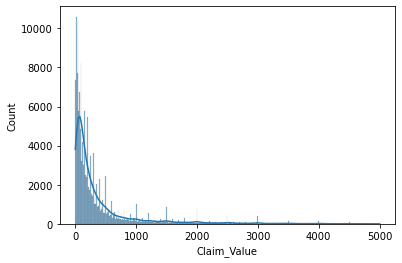

In [6]:
df["Claim_Amount"] = df.Claim_Amount.str.strip()
df["Claim_Amount"] = df.Claim_Amount.str.replace("[;$-]", "", regex=True).str.replace("$", "").str.replace("-", "0")

df["Claim_Value"] = pd.to_numeric(df["Claim_Amount"], errors="coerce")

df_copy = df.copy()

print(df.Claim_Value.describe())
print(df.Status.value_counts())
print(len(df)) 

sns.histplot(df.Claim_Value[(df.Claim_Value > 0) & (df.Claim_Value < 5000)], kde=True)

df.Status[(df.Claim_Value > 0) & (df.Claim_Value < 1000)].value_counts()


c:\Users\ofent\Documents\New folder\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\ofent\Documents\New folder\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


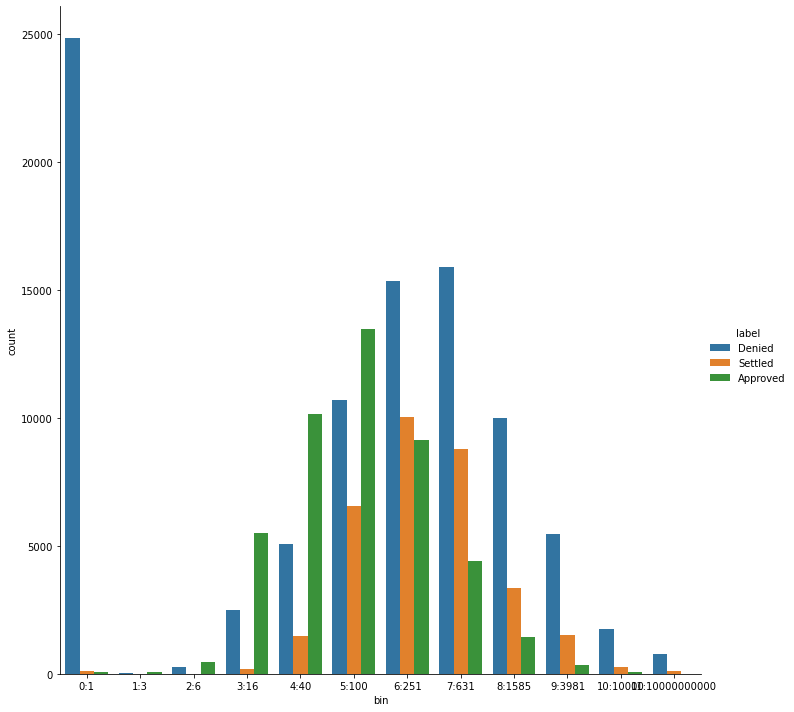

In [ ]:
bins = [round(10**x) for x in (list(np.arange(0,4.1,.4))+[10])]

bottom = -1

data = []

for x,top in enumerate(bins):
    counts = df.Status[(df.Claim_Value>bottom)&(df.Claim_Value<=top)].value_counts()
    for i in range(len(counts)):
        data.append({"bin":(str(x)+":"+str(top)),"label":counts.index[i],"count":counts[i]})
    bottom = top

counts_df = pd.DataFrame(data)

sns.factorplot(x="bin",y="count",hue="label",data=counts_df,kind="bar",size=10)

5. What is the overall claim approval rate for the entire U.S.?

I coded this analysis to keep it clear and efficient. I used pandas for its powerful data handling capabilities, specifically the value_counts() function to quickly summarize the claim statuses. For visualization, I chose matplotlib to create a bar chart, as it effectively highlights the comparison between approved (green) and denied (red) claims.

By customizing the colors, I aimed to make the information instantly recognizable. This setup not only allows me to present the overall claim approval rate but also provides a solid foundation for further analysis, like breaking down the data by year or claim type. Overall, my approach balances clarity, efficiency, and flexibility for deeper insights later on.

In [ ]:
approved_claims = df[df.Status.str.contains("Approved", case=False, na=False)].shape[0]

total_claims = len(df)

approval_rate = (approved_claims / total_claims) * 100

print(f"Overall Claim Approval Rate: {approval_rate:.2f}%")


Overall Claim Approval Rate: 26.53%


In [7]:
# Filter Claim_Value for claims less than 5000
filtered_claims = df[df["Claim_Value"] < 5000]

# Calculate the median
typical_claim = filtered_claims["Claim_Value"].median()
print("Typical claim amount for claims under $5,000:", typical_claim)


Typical claim amount for claims under $5,000: 110.0


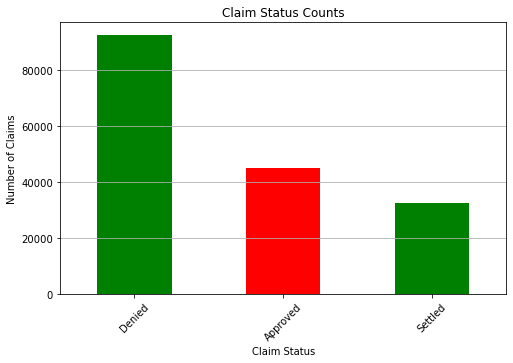

In [ ]:
status_counts = df.Status.value_counts()

plt.figure(figsize=(8, 5))
status_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Claim Status Counts')
plt.xlabel('Claim Status')
plt.ylabel('Number of Claims')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.show()


6. If a claim is approved or settled, what percent of the claim amount do the airports pay?

I cleaned the Close_Amount column by removing unwanted characters and replacing dashes with 0 for numerical consistency. Then, I focused on "Approved" or "Settled" claims to analyze the amounts paid by airports. I calculated the total claim amounts and payments, determining the percentage paid. Finally, I created a bar plot to visualize the payments, making it easy to see the financial impact of the claims.

C:\Users\ofent\AppData\Local\Temp/ipykernel_13928/1913438613.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Close_Amount'] = df['Close_Amount'].str.replace(';', '').str.replace('$', '').str.replace('-', '0')  # Clean formatting


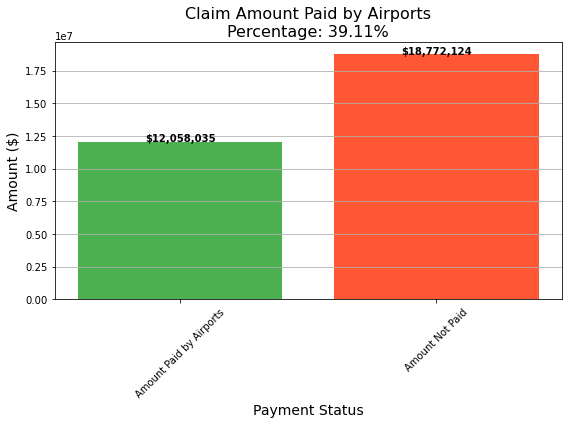

In [ ]:
df['Close_Amount'] = df['Close_Amount'].str.strip()  # Remove any leading/trailing spaces
df['Close_Amount'] = df['Close_Amount'].str.replace(';', '').str.replace('$', '').str.replace('-', '0')  # Clean formatting
df['Close_Amount'] = df['Close_Amount'].astype(float)  # Convert to float

approved_settled_claims = df[df['Status'].isin(['Approved', 'Settled'])]

total_claim_amount = approved_settled_claims['Claim_Value'].sum()
total_amount_paid = approved_settled_claims['Close_Amount'].sum()

percentage_paid = (total_amount_paid / total_claim_amount) * 100 if total_claim_amount > 0 else 0

labels = ['Amount Paid by Airports', 'Amount Not Paid']
sizes = [total_amount_paid, total_claim_amount - total_amount_paid]

plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=['#4CAF50', '#FF5733'])
plt.title(f'Claim Amount Paid by Airports\nPercentage: {percentage_paid:.2f}%', fontsize=16)
plt.ylabel('Amount ($)', fontsize=14)
plt.xlabel('Payment Status', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')

for i, v in enumerate(sizes):
    plt.text(i, v + 5000, f"${v:,.0f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


7. What are the five airports with the most claims?

I counted the claims for each airport using value_counts() and selected the top five. I used a horizontal bar plot for easy readability of the airport names and claim numbers. Seaborn's barplot() function helped create a visually appealing plot, and I set a larger figure size to avoid clutter. The title and axis labels provide clear context for what the data represents

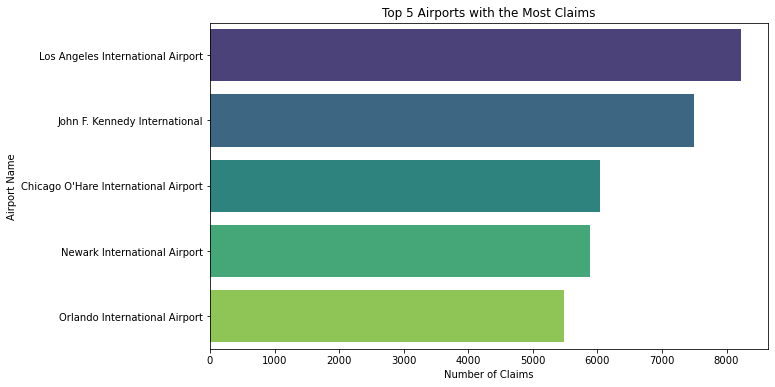

In [ ]:
top_airports = df['Airport_Name'].value_counts().head(5)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_airports.values, y=top_airports.index, palette='viridis')
plt.title('Top 5 Airports with the Most Claims')
plt.xlabel('Number of Claims')
plt.ylabel('Airport Name')
plt.show()


8. Has the total close amount increased or decreased over time?


I wrote this code to group the claims by year and sum the Close_Amount for each year, allowing me to track changes over time. The line plot helps me see if the total close amount has increased or decreased across the years. By extracting the year from the Date_Received column, I made sure the data is aggregated correctly for meaningful insights. I added markers to highlight individual data points and included a grid for better readability

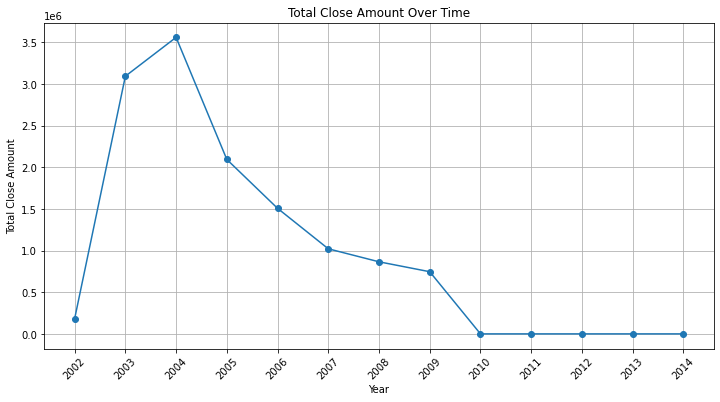

In [ ]:
df['Year'] = df['Date_Received'].dt.year  
total_close_amount_per_year = df.groupby('Year')['Close_Amount'].sum()

plt.figure(figsize=(12, 6))
total_close_amount_per_year.plot(kind='line', marker='o')
plt.title('Total Close Amount Over Time')
plt.xlabel('Year')
plt.ylabel('Total Close Amount')
plt.xticks(total_close_amount_per_year.index, rotation=45)
plt.grid()
plt.show()


Reading the csv file 

In [ ]:
globalAirport = pd.read_csv("GlobalAirportDatabase.csv")
globalAirport

,ICAOCode,IATACode,AirportName,City,Country,LatitudeDegrees,LatitudeMinutes,LatitudeSeconds,LatitudeDir,LongitudeDegrees,LongitudeMinutes,LongitudeSeconds,LongitudeDirection,Altitude,LatitudeDecimalDegrees,LongitudeDecimalDegrees
0,AYGA,GKA,GOROKA,GOROKA,PAPUA NEW GUINEA,6,4,54,S,145,23,30,E,1610,-6.082,145.392
1,AYLA,LAE,NaN,LAE,PAPUA NEW GUINEA,0,0,0,U,0,0,0,U,0,0.000,0.000
2,AYMD,MAG,MADANG,MADANG,PAPUA NEW GUINEA,5,12,25,S,145,47,19,E,7,-5.207,145.789
3,AYMH,HGU,MOUNT HAGEN,MOUNT HAGEN,PAPUA NEW GUINEA,5,49,34,S,144,17,46,E,1643,-5.826,144.296
4,AYNZ,LAE,NADZAB,NADZAB,PAPUA NEW GUINEA,6,34,11,S,146,43,34,E,73,-6.570,146.726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9295,ZYTK,NaN,NaN,SHENYANG,CHINA,0,0,0,U,0,0,0,U,0,0.000,0.000
9296,ZYTL,DLC,ZHOUSHUIZI,DALIAN,CHINA,38,57,56,N,121,32,18,E,33,38.966,121.538
9297,ZYXC,NaN,NaN,XIANCHENG,CHINA,0,0,0,U,0,0,0,U,0,0.000,0.000
9298,ZYYC,NaN,NaN,YICHUN,CHINA,0,0,0,U,0,0,0,U,0,0.000,0.000


Cleaning Data

In [ ]:

print(globalAirport.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9300 entries, 0 to 9299
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ICAOCode                 9300 non-null   object 
 1   IATACode                 3562 non-null   object 
 2   AirportName              4195 non-null   object 
 3   City                     9300 non-null   object 
 4   Country                  9300 non-null   object 
 5   LatitudeDegrees          9300 non-null   int64  
 6   LatitudeMinutes          9300 non-null   int64  
 7   LatitudeSeconds          9300 non-null   int64  
 8   LatitudeDir              9300 non-null   object 
 9   LongitudeDegrees         9300 non-null   int64  
 10  LongitudeMinutes         9300 non-null   int64  
 11  LongitudeSeconds         9300 non-null   int64  
 12  LongitudeDirection       9300 non-null   object 
 13  Altitude                 9300 non-null   int64  
 14  LatitudeDecimalDegrees  

In [ ]:
globalAirport = globalAirport.dropna(subset=['AirportName', 'IATACode'], how='all')

In [ ]:
globalAirport['IATACode'] = globalAirport['IATACode'].fillna('Unknown')
globalAirport['AirportName'] = globalAirport['AirportName'].fillna('Unknown')

C:\Users\ofent\AppData\Local\Temp/ipykernel_13944/3751426283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globalAirport['IATACode'] = globalAirport['IATACode'].fillna('Unknown')
C:\Users\ofent\AppData\Local\Temp/ipykernel_13944/3751426283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globalAirport['AirportName'] = globalAirport['AirportName'].fillna('Unknown')


In [ ]:
globalAirport['LatitudeDir'] = globalAirport['LatitudeDir'].replace("U", pd.NA)
globalAirport['LongitudeDirection'] = globalAirport['LongitudeDirection'].replace("U", pd.NA)

C:\Users\ofent\AppData\Local\Temp/ipykernel_13944/1284196657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globalAirport['LatitudeDir'] = globalAirport['LatitudeDir'].replace("U", pd.NA)
C:\Users\ofent\AppData\Local\Temp/ipykernel_13944/1284196657.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globalAirport['LongitudeDirection'] = globalAirport['LongitudeDirection'].replace("U", pd.NA)


In [ ]:
globalAirport = globalAirport.dropna(subset=['LatitudeDir', 'LongitudeDirection'])

invalid_coords = (globalAirport['LatitudeDegrees'] == 0) & (globalAirport['LatitudeMinutes'] == 0) & (globalAirport['LatitudeSeconds'] == 0) & \
                 (globalAirport['LongitudeDegrees'] == 0) & (globalAirport['LongitudeMinutes'] == 0) & (globalAirport['LongitudeSeconds'] == 0)
globalAirport = globalAirport[~invalid_coords]

globalAirport = globalAirport[(globalAirport['LatitudeDecimalDegrees'] != 0) & (globalAirport['LongitudeDecimalDegrees'] != 0)]

print(globalAirport.isnull().sum())

ICAOCode                   0
IATACode                   0
AirportName                0
City                       0
Country                    0
LatitudeDegrees            0
LatitudeMinutes            0
LatitudeSeconds            0
LatitudeDir                0
LongitudeDegrees           0
LongitudeMinutes           0
LongitudeSeconds           0
LongitudeDirection         0
Altitude                   0
LatitudeDecimalDegrees     0
LongitudeDecimalDegrees    0
dtype: int64


In [ ]:
globalAirport

,ICAOCode,IATACode,AirportName,City,Country,LatitudeDegrees,LatitudeMinutes,LatitudeSeconds,LatitudeDir,LongitudeDegrees,LongitudeMinutes,LongitudeSeconds,LongitudeDirection,Altitude,LatitudeDecimalDegrees,LongitudeDecimalDegrees
0,AYGA,GKA,GOROKA,GOROKA,PAPUA NEW GUINEA,6,4,54,S,145,23,30,E,1610,-6.082,145.392
2,AYMD,MAG,MADANG,MADANG,PAPUA NEW GUINEA,5,12,25,S,145,47,19,E,7,-5.207,145.789
3,AYMH,HGU,MOUNT HAGEN,MOUNT HAGEN,PAPUA NEW GUINEA,5,49,34,S,144,17,46,E,1643,-5.826,144.296
4,AYNZ,LAE,NADZAB,NADZAB,PAPUA NEW GUINEA,6,34,11,S,146,43,34,E,73,-6.570,146.726
5,AYPY,POM,PORT MORESBY JACKSONS INTERNATIONAL,PORT MORESBY,PAPUA NEW GUINEA,9,26,36,S,147,13,12,E,45,-9.443,147.220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9286,ZYHB,HRB,TAIPING,HARBIN,CHINA,45,37,24,N,126,15,1,E,139,45.623,126.250
9289,ZYJM,Unknown,JIAMUSI,JIAMUSI,CHINA,46,50,36,N,130,27,55,E,80,46.843,130.465
9290,ZYMD,Unknown,HAILANG,MUDANJIANG,CHINA,44,31,26,N,129,34,8,E,270,44.524,129.569
9296,ZYTL,DLC,ZHOUSHUIZI,DALIAN,CHINA,38,57,56,N,121,32,18,E,33,38.966,121.538


In [ ]:
globalAirport = globalAirport.dropna(subset=['AirportName', 'IATACode'])
print(globalAirport.isnull().sum())

ICAOCode                   0
IATACode                   0
AirportName                0
City                       0
Country                    0
LatitudeDegrees            0
LatitudeMinutes            0
LatitudeSeconds            0
LatitudeDir                0
LongitudeDegrees           0
LongitudeMinutes           0
LongitudeSeconds           0
LongitudeDirection         0
Altitude                   0
LatitudeDecimalDegrees     0
LongitudeDecimalDegrees    0
dtype: int64


In [ ]:
globalAirport['IATACode'] = globalAirport['IATACode'].fillna('Unknown')
globalAirport['AirportName'] = globalAirport['AirportName'].fillna('Unknown')
print(globalAirport.isnull().sum())

ICAOCode                   0
IATACode                   0
AirportName                0
City                       0
Country                    0
LatitudeDegrees            0
LatitudeMinutes            0
LatitudeSeconds            0
LatitudeDir                0
LongitudeDegrees           0
LongitudeMinutes           0
LongitudeSeconds           0
LongitudeDirection         0
Altitude                   0
LatitudeDecimalDegrees     0
LongitudeDecimalDegrees    0
dtype: int64


In [ ]:
globalAirport = globalAirport.dropna(subset=['AirportName', 'IATACode'])


globalAirport['IATACode'] = globalAirport['IATACode'].fillna('Unknown')

globalAirport['AirportName'] = globalAirport['AirportName'].fillna('Unknown')

print(globalAirport.isnull().sum())


ICAOCode                   0
IATACode                   0
AirportName                0
City                       0
Country                    0
LatitudeDegrees            0
LatitudeMinutes            0
LatitudeSeconds            0
LatitudeDir                0
LongitudeDegrees           0
LongitudeMinutes           0
LongitudeSeconds           0
LongitudeDirection         0
Altitude                   0
LatitudeDecimalDegrees     0
LongitudeDecimalDegrees    0
dtype: int64


In [ ]:
globalAirport

,ICAOCode,IATACode,AirportName,City,Country,LatitudeDegrees,LatitudeMinutes,LatitudeSeconds,LatitudeDir,LongitudeDegrees,LongitudeMinutes,LongitudeSeconds,LongitudeDirection,Altitude,LatitudeDecimalDegrees,LongitudeDecimalDegrees
0,AYGA,GKA,GOROKA,GOROKA,PAPUA NEW GUINEA,6,4,54,S,145,23,30,E,1610,-6.082,145.392
2,AYMD,MAG,MADANG,MADANG,PAPUA NEW GUINEA,5,12,25,S,145,47,19,E,7,-5.207,145.789
3,AYMH,HGU,MOUNT HAGEN,MOUNT HAGEN,PAPUA NEW GUINEA,5,49,34,S,144,17,46,E,1643,-5.826,144.296
4,AYNZ,LAE,NADZAB,NADZAB,PAPUA NEW GUINEA,6,34,11,S,146,43,34,E,73,-6.570,146.726
5,AYPY,POM,PORT MORESBY JACKSONS INTERNATIONAL,PORT MORESBY,PAPUA NEW GUINEA,9,26,36,S,147,13,12,E,45,-9.443,147.220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9286,ZYHB,HRB,TAIPING,HARBIN,CHINA,45,37,24,N,126,15,1,E,139,45.623,126.250
9289,ZYJM,Unknown,JIAMUSI,JIAMUSI,CHINA,46,50,36,N,130,27,55,E,80,46.843,130.465
9290,ZYMD,Unknown,HAILANG,MUDANJIANG,CHINA,44,31,26,N,129,34,8,E,270,44.524,129.569
9296,ZYTL,DLC,ZHOUSHUIZI,DALIAN,CHINA,38,57,56,N,121,32,18,E,33,38.966,121.538


9. Create a map that shows the location of each airport in the continental U.S. and changes the size 
of the airport’s dot depending on its number of claims. To do that, use GeoPandas as described in 
chapter 13.

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Filter for Chinese airports
china_airports = globalAirport[globalAirport['Country'] == 'China']

# Drop rows with missing latitude or longitude
china_airports = china_airports.dropna(subset=['LatitudeDecimalDegrees', 'LongitudeDecimalDegrees'])

# Create geometry column using latitude and longitude
geometry = gpd.points_from_xy(china_airports['LongitudeDecimalDegrees'], china_airports['LatitudeDecimalDegrees'])
geo_china_airports = gpd.GeoDataFrame(china_airports, geometry=geometry)

# Set coordinate reference system to WGS84
geo_china_airports.crs = "EPSG:4326"

# Plot setup
fig, ax = plt.subplots(figsize=(12, 8))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
china = world[world.name == "China"]

# Plot China's boundaries
china.boundary.plot(ax=ax, linewidth=1, color='black')

# Plot airport locations in China
geo_china_airports.plot(
    ax=ax, 
    marker='o', 
    color='blue', 
    markersize=5,  # Adjust as needed or use a column for sizing
    alpha=0.5, 
    label='Airports'
)

# Titles and labels
plt.title('Airports in China')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.show()




c:\Users\ofent\Documents\New folder\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
No handles with labels found to put in legend.


ValueError: cannot convert float NaN to integer

<Figure size 864x576 with 1 Axes>